# Chapter 6: A Journey Into Sound

In [1]:
pip install torchaudio

     |████████████████████████████████| 2.9 MB 12.4 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:41tcmalloc: large alloc 1147494400 bytes == 0x564a2d68c000 @  0x7f7388aa2615 0x5649f49a64cc 0x5649f4a8647a 0x5649f49a92ed 0x5649f4a9ae1d 0x5649f4a1ce99 0x5649f4a179ee 0x5649f49aabda 0x5649f4a1cd00 0x5649f4a179ee 0x5649f49aabda 0x5649f4a19737 0x5649f4a9bc66 0x5649f4a18daf 0x5649f4a9bc66 0x5649f4a18daf 0x5649f4a9bc66 0x5649f4a18daf 0x5649f49ab039 0x5649f49ee409 0x5649f49a9c52 0x5649f4a1cc25 0x5649f4a179ee 0x5649f49aabda 0x5649f4a19737 0x5649f4a179ee 0x5649f49aabda 0x5649f4a18915 0x5649f49aaafa 0x5649f4a18c0d 0x5649f4a179ee
     |████████████████████████████████| 881.9 MB 22 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import IPython.display as display
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchaudio
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torchvision import models, transforms
import glob

In [3]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))
        
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

In [ ]:
display.Audio('/content/drive/MyDrive/Datasets/ESC-50-master/split_on_index/train/1-100032-A-0.wav')

In [ ]:
import glob
from collections import Counter

esc50_list = [f.split("-")[-1].replace(".wav","") for f in glob.glob("/content/drive/MyDrive/Datasets/ESC-50-master/audio/*.wav")]
Counter(esc50_list)

In [ ]:
files = Path('/content/drive/MyDrive/Datasets/ESC-50-master/audio/').glob('*.wav')
items_ = [(str(f),f.name.split("-")[-1].replace(".wav","")) for f in files]

In [ ]:
items_[2]

('/content/drive/MyDrive/Datasets/ESC-50-master/audio/5-221567-A-22.wav', '22')

In [ ]:
len(Counter(esc50_list))

50

# ESC-50 Dataset & DataLoaders

In [4]:
class ESC50(Dataset):
    def __init__(self,path):
        # Get directory listing from path
        files = Path(path).glob('*.wav')
        # Iterate through the listing and create a list of tuples (filename, label)
        self.items = [(str(f),f.name.split("-")[-1].replace(".wav","")) for f in files]
        self.length = len(self.items)
    def __getitem__(self, index):
        filename, label = self.items[index]
        audioTensor, rate = torchaudio.load(filename)
        return (audioTensor, int(label))     
    def __len__(self):
        return self.length

In [5]:
import os
def mk_dir(name):
    if(os.path.isdir(name)==False):
        os.mkdir(name)

In [ ]:
base_dir = '/content/drive/MyDrive/Datasets/ESC-50-master/split_on_index/'

In [ ]:
train_dir = os.path.join(base_dir, 'train')
mk_dir(train_dir)
validation_dir = os.path.join(base_dir, 'valid')
mk_dir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
mk_dir(test_dir)

In [ ]:
import shutil

train_filenames = []
for i in range(1,4):
    a = glob.glob(f"/content/drive/MyDrive/Datasets/ESC-50-master/audio/{i}*")
    train_filenames.append(a)
for filelist in train_filenames:
    for filename in filelist:
        shutil.copy(filename, '/content/drive/MyDrive/Datasets/ESC-50-master/split_on_index/train/')

valid_filenames = glob.glob("/content/drive/MyDrive/Datasets/ESC-50-master/audio/4*")
for filename in valid_filenames:
    shutil.copy(filename, '/content/drive/MyDrive/Datasets/ESC-50-master/split_on_index/valid/')

test_filenames = glob.glob("/content/drive/MyDrive/Datasets/ESC-50-master/audio/5*")
for filename in test_filenames:
    shutil.copy(filename, '/content/drive/MyDrive/Datasets/ESC-50-master/split_on_index/test/')




In [ ]:
len(test_filenames)

400

In [6]:
device="cuda"
bs=64
PATH_TO_ESC50 = '/content/drive/MyDrive/Datasets/ESC-50-master/split_on_index/'

train_esc50 = ESC50(f"{PATH_TO_ESC50}/train")
valid_esc50 = ESC50(f"{PATH_TO_ESC50}/valid")
test_esc50  = ESC50(f"{PATH_TO_ESC50}/test")

train_loader = torch.utils.data.DataLoader(train_esc50, batch_size = bs, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_esc50, batch_size = bs, shuffle = True)
test_loader  = torch.utils.data.DataLoader(test_esc50, batch_size = bs, shuffle = True)

In [ ]:
list(test_esc50)[0]

KeyboardInterrupt: ignored

# M5-based CNN AudioNet

In [7]:
class AudioNet(nn.Module):
    def __init__(self):
        super(AudioNet, self).__init__()
        self.conv1 = nn.Conv1d(100, 128, kernel_size=5, stride=4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(512, 50)

    def forward(self, x):
        x = x.unsqueeze(-1).view(-1, 100, 2205)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = x.squeeze(-1)
        x = self.fc1(x)
        return x

In [ ]:
audionet = AudioNet()
audionet.to(device)

AudioNet(
  (conv1): Conv1d(100, 128, kernel_size=(5,), stride=(4,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=50, 

# Find learning rate & train

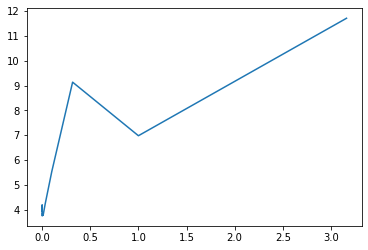

In [ ]:
torch.save(audionet.state_dict(), "audionet.pth")
optimizer = optim.Adam(audionet.parameters(), lr=0.001)
logs,losses = find_lr(audionet, nn.CrossEntropyLoss(), optimizer, train_loader, device=device)

plt.plot(logs,losses)

In [ ]:
lr = 1e-5
audionet.load_state_dict(torch.load("audionet.pth"))
optimizer = optim.Adam(audionet.parameters(), lr=lr)

In [ ]:
train(audionet, optimizer, torch.nn.CrossEntropyLoss(),train_loader, valid_loader, epochs=20, device=device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1, Training Loss: 3.12, Validation Loss: 3.65, accuracy = 0.07
Epoch: 2, Training Loss: 3.10, Validation Loss: 3.64, accuracy = 0.08
Epoch: 3, Training Loss: 3.07, Validation Loss: 3.63, accuracy = 0.09
Epoch: 4, Training Loss: 3.04, Validation Loss: 3.63, accuracy = 0.09
Epoch: 5, Training Loss: 3.02, Validation Loss: 3.62, accuracy = 0.09
Epoch: 6, Training Loss: 2.99, Validation Loss: 3.62, accuracy = 0.09
Epoch: 7, Training Loss: 2.96, Validation Loss: 3.62, accuracy = 0.08
Epoch: 8, Training Loss: 2.93, Validation Loss: 3.61, accuracy = 0.09
Epoch: 9, Training Loss: 2.91, Validation Loss: 3.60, accuracy = 0.09
Epoch: 10, Training Loss: 2.88, Validation Loss: 3.60, accuracy = 0.08
Epoch: 11, Training Loss: 2.86, Validation Loss: 3.59, accuracy = 0.09
Epoch: 12, Training Loss: 2.84, Validation Loss: 3.59, accuracy = 0.09
Epoch: 13, Training Loss: 2.81, Validation Loss: 3.58, accuracy = 0.08
Epoch: 14, Training Loss: 2.79, Validation Loss: 3.58, accuracy = 0.09
Epoch: 15, Trai

# Using Spectrograms

In [ ]:
sample_data, sr = librosa.load("/content/drive/MyDrive/Datasets/ESC-50-master/split_on_index/train/1-100032-A-0.wav", sr=None)
spectrogram = librosa.feature.melspectrogram(sample_data, sr=sr)

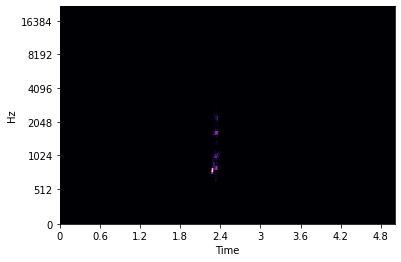

In [ ]:
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel')

In [ ]:
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)


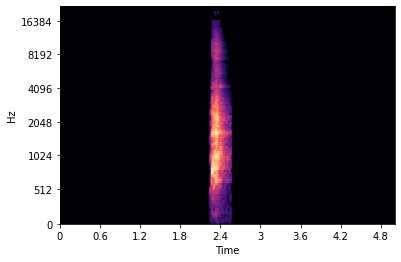

In [ ]:
librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')

Сохранение изображений спектрограмм на диск

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


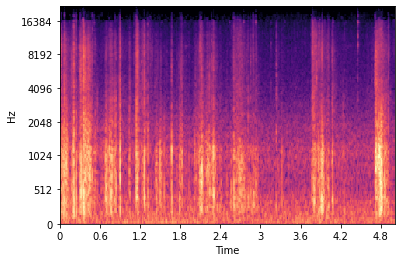

In [8]:
def precompute_spectrograms(path, dpi=50):
    files = Path(path).glob('*.wav')
    for filename in files:
      if os.path.exists(f"{filename.parent}{dpi}_{filename.name}.png") == False:
        audio_tensor, sr = librosa.load(filename, sr=None)
        spectrogram = librosa.feature.melspectrogram(audio_tensor, sr=sr)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
        plt.gcf().savefig("{}{}_{}.png".format(filename.parent,dpi,filename.name), dpi=dpi)

PATH_ESC50_TRAIN = f"{PATH_TO_ESC50}/train"
PATH_ESC50_VALID = f"{PATH_TO_ESC50}/valid"
PATH_ESC50_TEST = f"{PATH_TO_ESC50}/test"

precompute_spectrograms(PATH_ESC50_TRAIN)
precompute_spectrograms(PATH_ESC50_VALID)
precompute_spectrograms(PATH_ESC50_TEST)

In [ ]:
import shutil

train_filenames = glob.glob(f"/content/drive/MyDrive/Datasets/ESC-50-master/split_on_index/train50*")
for filename in train_filenames:
    shutil.move(filename, '/content/drive/MyDrive/Datasets/ESC-50-master/split_on_index/train/')

valid_filenames = glob.glob("/content/drive/MyDrive/Datasets/ESC-50-master/audio/valid50")
for filename in valid_filenames:
    shutil.move(filename, '/content/drive/MyDrive/Datasets/ESC-50-master/split_on_index/valid/')

test_filenames = glob.glob("/content/drive/MyDrive/Datasets/ESC-50-master/audio/test50*")
for filename in test_filenames:
    shutil.move(filename, '/content/drive/MyDrive/Datasets/ESC-50-master/split_on_index/test/')

In [ ]:
class PrecomputedESC50(Dataset):
    def __init__(self,path,dpi=50, img_transforms=None):
        files = Path(path).glob('{}{}*.wav.png'.format(path.name, dpi))
        self.items = [(f,int(f.name.split("-")[-1].replace(".wav.png",""))) for f in files]
        self.length = len(self.items)
        if img_transforms == None:
            self.img_transforms = transforms.Compose([transforms.ToTensor()])
        else:
            self.img_transforms = img_transforms
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename).convert('RGB')
        return (self.img_transforms(img), label)
            
    def __len__(self):
        return self.length

# Pretrained ResNet50

In [ ]:
spec_resnet = models.resnet50(pretrained=True)

for param in spec_resnet.parameters():
    param.requires_grad = False

spec_resnet.fc = nn.Sequential(nn.Linear(spec_resnet.fc.in_features,500),
                               nn.ReLU(),
                               nn.Dropout(), nn.Linear(500,50))

In [ ]:
esc50pre_train = PrecomputedESC50(PATH_ESC50_TRAIN,
                                  img_transforms=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
)

esc50pre_valid = PrecomputedESC50(PATH_ESC50_VALID,
                                  img_transforms=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
)

esc50pre_test = PrecomputedESC50(PATH_ESC50_TEST,
                                  img_transforms=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
)

esc50_train_loader = torch.utils.data.DataLoader(esc50pre_train, bs, shuffle=True)
esc50_val_loader = torch.utils.data.DataLoader(esc50pre_valid, bs, shuffle=True)
esc50_test_loader = torch.utils.data.DataLoader(esc50pre_test, bs, shuffle=True)

In [ ]:
spec_resnet.to(device) 
torch.save(spec_resnet.state_dict(), "spec_resnet.pth")
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(spec_resnet.parameters(), lr=lr)
logs,losses = find_lr(spec_resnet, loss_fn, optimizer, esc50_train_loader, device=device)
plt.plot(logs, losses)

In [ ]:
spec_resnet.load_state_dict(torch.load("spec_resnet.pth"))
optimizer = optim.Adam([
                        {'params': spec_resnet.conv1.parameters()},
                        {'params': spec_resnet.bn1.parameters()},
                        {'params': spec_resnet.relu.parameters()},
                        {'params': spec_resnet.maxpool.parameters()},
                        {'params': spec_resnet.layer1.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer2.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer3.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer4.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.avgpool.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.fc.parameters(), 'lr': 1e-8}
                        ], lr=1e-2)

train(spec_resnet, optimizer, nn.CrossEntropyLoss(), esc50_train_loader, esc50_val_loader, epochs=5, device=device)

for param in spec_resnet.parameters():
    param.requires_grad = True

train(spec_resnet, optimizer, nn.CrossEntropyLoss(), esc50_train_loader, esc50_val_loader, epochs=5, device=device)